In [1]:
import jax
import os

In [2]:
from sklearn import datasets
import scanpy as sc
import optax
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import numpy as np

import ott
import sklearn
import matplotlib.pyplot as plt
from ott.geometry import geometry, pointcloud
import jax
from typing import Mapping, Any, Optional, Union, Callable, Tuple
from types import MappingProxyType
import jax.numpy as jnp
from functools import partial
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem
from entot.models.model import OTFlowMatching
from entot.nets.nets import MLP_vector_field, MLP_bridge, MLP_marginal,MLP_fused_vector_field
import sklearn.preprocessing as pp
import scanpy as sc
from ott.solvers.linear import sinkhorn, acceleration
from sklearn import preprocessing as pp

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/equinox/_ad.py:753: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(
2023-09-12 09:13:30.855209: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not 

In [3]:
adata_atac = sc.read("../../data/bone_marrow_atac.h5ad")
adata_rna = sc.read("../../data/bone_marrow_rna.h5ad")

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


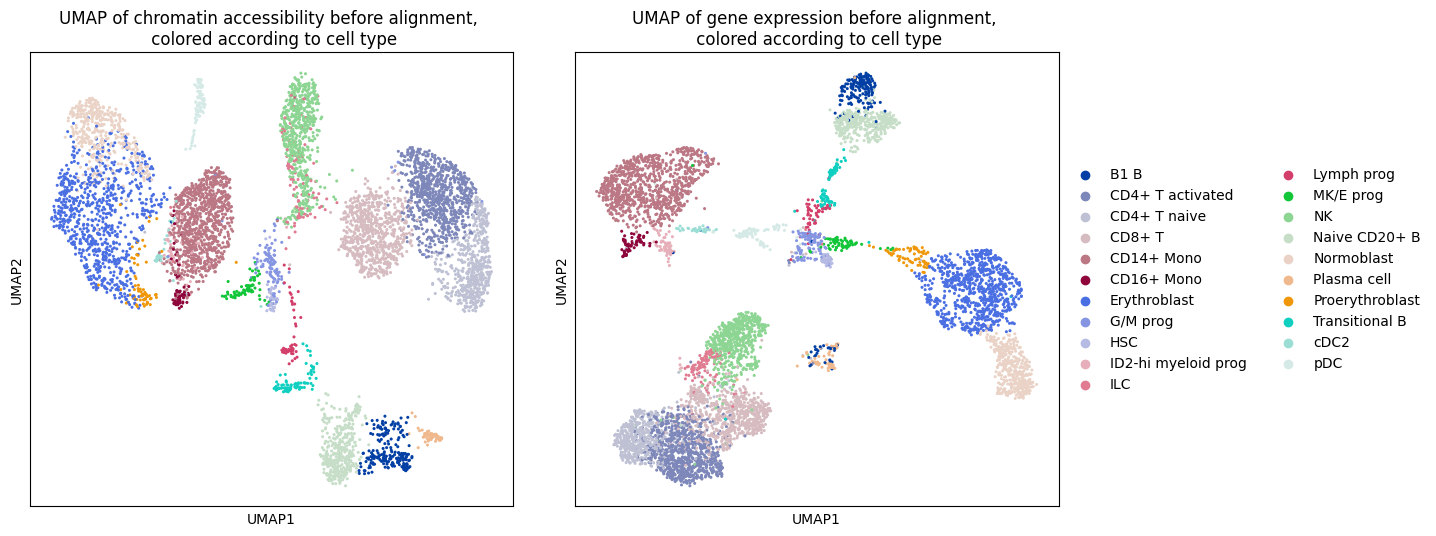

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata_atac, color="cell_type", ax=ax1, show=False)
ax1.legend().remove()
ax1.set_title(
    "UMAP of chromatin accessibility before alignment, \n colored according to cell type"
)
sc.pl.umap(adata_rna, color="cell_type", ax=ax2, show=False)
ax2.set_title(
    "UMAP of gene expression before alignment, \n colored according to cell type"
)
plt.tight_layout(pad=3.0)
plt.show()

In [5]:
source_q = pp.normalize(
    adata_atac.obsm["ATAC_lsi_red"], norm="l2"
) 
target_q = adata_rna.obsm["GEX_X_pca"]

source_fused = sc.pp.pca(adata_atac.obsm["geneactivity_scvi"], n_comps=10)
target_fused = sc.pp.pca(adata_rna.obsm["geneactivity_scvi"], n_comps=10)

In [6]:
source = np.concatenate((source_fused, source_q), axis=1)
target = np.concatenate((target_fused, target_q), axis=1)

In [67]:
adata_rna_red = adata_rna[~adata_rna.obs["cell_type"].isin(["Normoblast"])]

In [68]:
target_red = target[~adata_rna.obs["cell_type"].isin(["Normoblast"])]

In [77]:
neural_net = MLP_vector_field(target.shape[1], latent_embed_dim = 256, num_layers=8, n_frequencies=128)
bridge_net = MLP_bridge(target.shape[1], 10)
linear_ot_solver = sinkhorn.Sinkhorn(
                momentum=acceleration.Momentum(value=1., start=25)
        )
solver = ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein(epsilon=0.1, linear_ot_solver=linear_ot_solver)


mlp_eta = MLP_marginal(256, 5)
mlp_xi = MLP_marginal(256, 5)

otfm = OTFlowMatching(neural_net, bridge_net, epsilon=None, mlp_eta=mlp_eta, mlp_xi=mlp_xi, tau_a=0.9, tau_b=1.0, cost_fn="graph", graph_kwargs={"k_neighbors":1025}, scale_cost="mean", input_dim=source.shape[1], output_dim=target.shape[1], iterations=10_000, ot_solver=solver, k_noise_per_x=1, fused_penalty = 1.0, split_dim=source_fused.shape[1])

In [78]:
otfm.iterations=5_000
otfm(source, target_red, 1024, 1024)

100%|██████████| 5000/5000 [14:00<00:00,  5.95it/s]


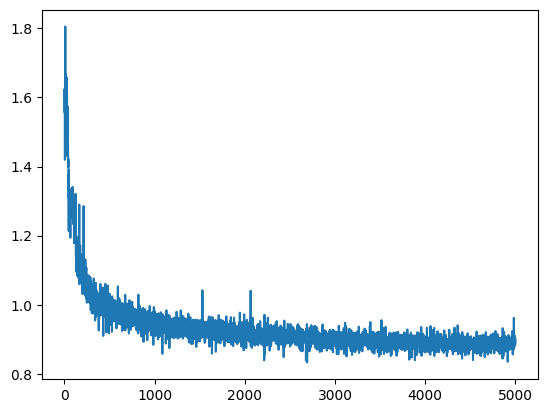

In [79]:
plt.plot(np.arange(len(otfm.metrics["loss"])), otfm.metrics["loss"])

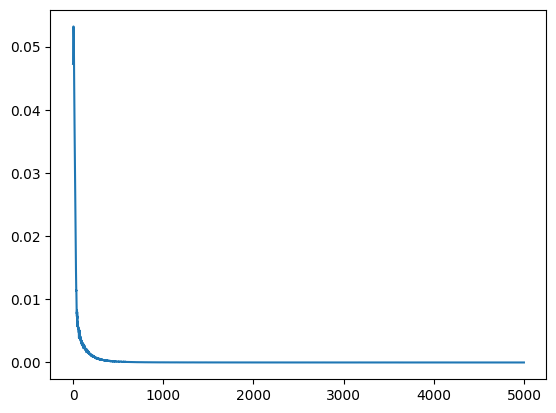

In [80]:
plt.plot(np.arange(len(otfm.metrics["loss"])), otfm.metrics["loss_eta"])

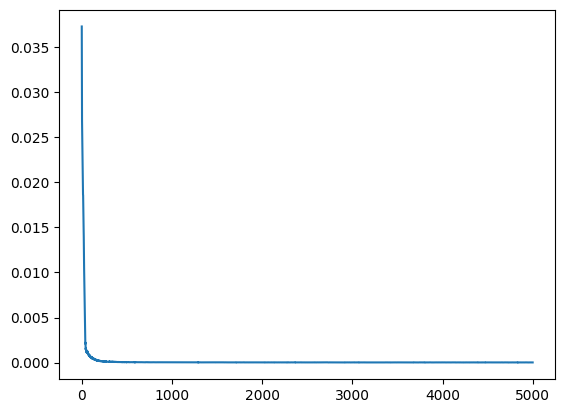

In [81]:
plt.plot(np.arange(len(otfm.metrics["loss"])), otfm.metrics["loss_xi"])

In [50]:

res = [None] * 10

for i in range(10):
    res[i] = otfm.transport(source, seed=i)[0][0,...]

gex_predicted = jnp.mean(np.asarray(res), axis=0)

In [32]:
def foscttm(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    d = scipy.spatial.distance_matrix(x, y)
    foscttm_x = (d < np.expand_dims(np.diag(d), axis=1)).mean(axis=1)
    foscttm_y = (d < np.expand_dims(np.diag(d), axis=0)).mean(axis=0)
    fracs = []
    for i in range(len(foscttm_x)):
        fracs.append((foscttm_x[i] + foscttm_y[i]) / 2)
    return np.mean(fracs).round(4)

In [52]:
gex_predicted_subset = gex_predicted[~adata_atac.obs["cell_type"].isin(["Normoblast"]).values]

In [34]:
gex_predicted.shape

(6224, 60)

In [53]:
import scipy
foscttm(gex_predicted_subset, target_red)

0.4194

In [51]:
foscttm(gex_predicted, target)

0.4421

In [ ]:
foscttm(gex_predicted, target)

In [ ]:
#TODO: check that the adatas we concatenate are correct!!!

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


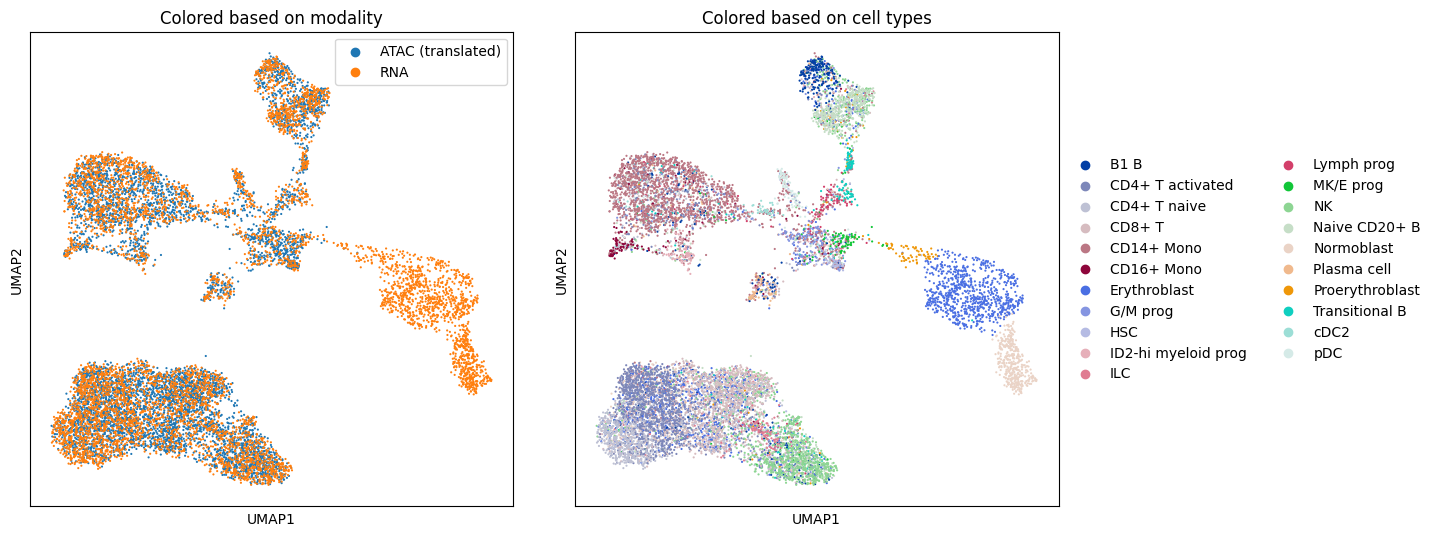

In [54]:
import scanpy as sc
adata = sc.concat(
    [adata_atac, adata_rna],
    join="outer",
    label="batch",
    keys=["ATAC (translated)", "RNA"],
)
adata.obsm["X_translated_1"] = np.concatenate(
    (res[0], target), axis=0
)
sc.pp.neighbors(adata, use_rep="X_translated_1")
sc.tl.umap(adata)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata, color=["batch"], ax=ax1, show=False)
ax1.legend()
ax1.set_title("Colored based on modality")
sc.pl.umap(adata, color=["cell_type"], ax=ax2, show=False)
ax2.set_title("Colored based on cell types")
plt.tight_layout(pad=3.0)
plt.show()

In [82]:
lm = otfm.state_eta.apply_fn({"params": otfm.state_eta.params}, x=source)
lms = np.zeros((len(adata),1))
lms[:] = None
lms[adata.obs["batch"] == "ATAC (translated)"] = lm
adata.obs["left_marginals"] = lms
rm = otfm.state_xi.apply_fn({"params": otfm.state_xi.params}, x=target)
rms = np.zeros((len(adata),1))
rms[:] = None
rms[adata.obs["batch"] == "RNA"] = rm
adata.obs["right_marginals"] = rms

In [83]:
adata[adata.obs["batch"] == "ATAC (translated)"].obs[["cell_type", "left_marginals"]].groupby("cell_type").mean()

,left_marginals
cell_type,
B1 B,0.999831
CD4+ T activated,0.999505
CD4+ T naive,0.999390
CD8+ T,0.999933
CD14+ Mono,1.000105
CD16+ Mono,0.999884
Erythroblast,1.000398
G/M prog,1.000511
HSC,1.000548


In [84]:
adata[adata.obs["batch"] == "RNA"].obs[["cell_type", "right_marginals"]].groupby("cell_type").mean()

,right_marginals
cell_type,
B1 B,0.998300
CD4+ T activated,0.999997
CD4+ T naive,1.000908
CD8+ T,1.000601
CD14+ Mono,1.002309
CD16+ Mono,0.996662
Erythroblast,0.999401
G/M prog,0.995261
HSC,0.994073


In [ ]:
foscttm(gex_predicted[..., 25:], target[..., 25:])

In [ ]:
foscttm(gex_predicted[..., :25], target[..., :25])

In [ ]:
foscttm(jnp.mean(gex_predicted, axis=0)[..., 10:], target[..., 10:])

In [ ]:
gex_predicted

In [ ]:
res = [None] * 15

for i in range(15):
    res[i]= otfm.transport(source_concat, seed=i)[0][0,...]

In [ ]:
gex_predicted = jnp.mean(jnp.asarray(res), axis=0)

In [ ]:
foscttm(gex_predicted, target_concat)

In [ ]:
foscttm(gex_predicted[..., 10:], target_concat[..., 10:])

In [ ]:
foscttm(gex_predicted[..., :10], target_concat[..., :10])

In [ ]:
samples = jnp.array(res)
vars = jnp.var(samples, axis=0)
vars_summed = jnp.sum(vars, axis=1)

In [ ]:
fill = np.empty(len(target))[:, None]
fill[:] = np.nan
adata.obs["var"] = np.asarray(np.concatenate((vars_summed[:, None], fill)))

In [ ]:
sc.pl.umap(adata, color="var", vmax="p99")

In [ ]:
adata.obs[["cell_type", "var"]].groupby("cell_type").mean()

In [ ]:
sc.tl.dendrogram(adata, groupby="cell_type")

In [ ]:
sc.pl.dendrogram(adata, groupby="cell_type")

In [ ]:
sc.pl.correlation_matrix(adata, groupby="cell_type")